In [1]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collab.foraging.toolkit import (
    animate_predictors,
    dataObject,
    generate_local_windows,
    generate_pairwiseCopying_predictor,
    generate_vicsek_predictor,
    rescale_to_grid,
    subsample_frames_constant_frame_rate,
)
from IPython.display import HTML

mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline

# Create `dataObject` with test data from experiments 

In [2]:
# load data

fish_data = pd.read_csv("4wpf_test.csv")
gridMin = 0
gridMax = 300
grid_size = 50
fps = 121

# scaling and subsampling
fishDF_scaled = rescale_to_grid(
    fish_data, size=grid_size, gridMin=gridMin, gridMax=gridMax
)
fishDF_scaled_subsampled = subsample_frames_constant_frame_rate(
    fishDF_scaled, frame_spacing=60
)

# create a test foragers object with chosen number of frames
num_frames = 20
foragers_object = dataObject(
    fishDF_scaled_subsampled.loc[fishDF_scaled_subsampled["time"] < num_frames],
    grid_size=grid_size,
)

# choose local windows params, and compute
local_windows_kwargs = {
    "window_size": grid_size / 2,
    "sampling_fraction": 1,
    "skip_incomplete_frames": True,
}

foragers_object.local_windows_kwargs = local_windows_kwargs
local_windows = generate_local_windows(foragers_object)
foragers_object.local_windows = local_windows

FileNotFoundError: [Errno 2] No such file or directory: '4wpf_test.csv'

# Vicsek predictor

2024-09-18 18:20:51,114 - Animation.save using <class 'matplotlib.animation.HTMLWriter'>


20


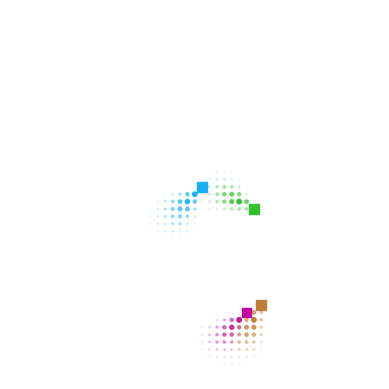

In [3]:
# choose predictor kwargs and add to object
predictor_kwargs = {
    "vicsek": {
        "interaction_length": grid_size / 3,
        "interaction_constraint": None,
        "interaction_constraint_params": {},
        "dt": 1,
        "sigma_v": 3,
        "sigma_t": 0.3,
    }
}

foragers_object.predictor_kwargs = predictor_kwargs
vicsek_predictor = generate_vicsek_predictor(foragers_object, "vicsek")

ani = animate_predictors(
    foragers_object.foragersDF,
    vicsek_predictor,
    predictor_name="vicsek",
    forager_position_indices=[0, 1, 2, 3],
    forager_predictor_indices=[0, 1, 2, 3],
    grid_size=grid_size,
    random_state=10,
    size_multiplier=10,
)
HTML(ani.to_jshtml())

# How correlated are vicsek & pairwiseCopying predictors? 

In [3]:
# create dataObject with all the frames
fish_data = pd.read_csv("4wpf_test.csv")
gridMin = 0
gridMax = 300
grid_size = 50
fps = 121

# scaling and subsampling
fishDF_scaled = rescale_to_grid(
    fish_data, size=grid_size, gridMin=gridMin, gridMax=gridMax
)
fishDF_scaled_subsampled = subsample_frames_constant_frame_rate(
    fishDF_scaled, frame_spacing=60
)

# create a test foragers object with all frames
foragers_object = dataObject(
    fishDF_scaled_subsampled,
    grid_size=grid_size,
)

# choose local windows params, and compute
local_windows_kwargs = {
    "window_size": grid_size / 2,
    "sampling_fraction": 1,
    "skip_incomplete_frames": True,
}

foragers_object.local_windows_kwargs = local_windows_kwargs
local_windows = generate_local_windows(foragers_object)
foragers_object.local_windows = local_windows

# choose predictor kwargs and add to object
predictor_kwargs = {
    "vicsek": {
        "interaction_length": grid_size / 3,
        "interaction_constraint": None,
        "interaction_constraint_params": {},
        "dt": 1,
        "sigma_v": 3,
        "sigma_t": 0.3,
    },
    "pairwiseCopying": {
        "interaction_length": grid_size / 3,
        "interaction_constraint": None,
        "interaction_constraint_params": {},
        "dt": 1,
        "sigma_v": 3,
        "sigma_t": 0.3,
    },
}

foragers_object.predictor_kwargs = predictor_kwargs

FileNotFoundError: [Errno 2] No such file or directory: '4wpf_test.csv'

In [5]:
vicsek_predictor = generate_vicsek_predictor(foragers_object, "vicsek")
pairwiseCopying_predictor = generate_pairwiseCopying_predictor(
    foragers_object, "pairwiseCopying"
)

In [6]:
# convert to DFs
vicsek_predictorDF = pd.concat([pd.concat(dfs) for dfs in vicsek_predictor])
pairwiseCopying_predictorDF = pd.concat(
    [pd.concat(dfs) for dfs in pairwiseCopying_predictor]
)

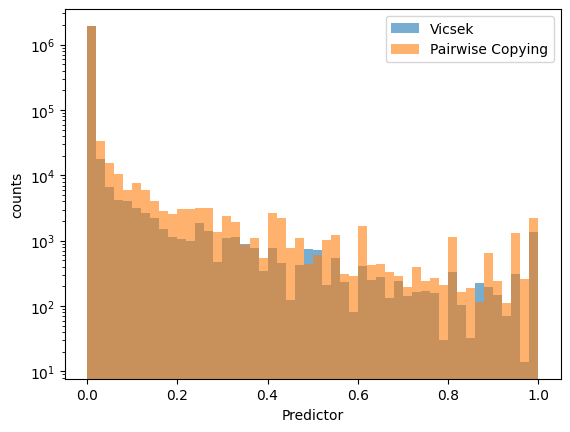

In [7]:
plt.hist(vicsek_predictorDF["vicsek"], bins=50, alpha=0.6, label="Vicsek")
plt.hist(
    pairwiseCopying_predictorDF["pairwiseCopying"],
    bins=50,
    alpha=0.6,
    label="Pairwise Copying",
)
plt.xlabel("Predictor")
plt.ylabel("counts")
plt.yscale("log")
plt.legend()
plt.show()

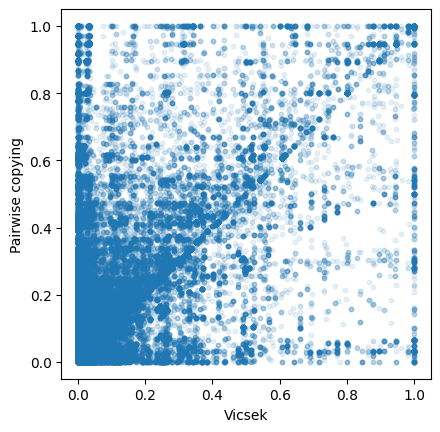

In [8]:
# mpl.use('Agg')
fig, ax = plt.subplots()
ax.scatter(
    vicsek_predictorDF["vicsek"],
    pairwiseCopying_predictorDF["pairwiseCopying"],
    alpha=0.1,
    s=10,
)
ax.set_aspect("equal")
ax.set_xlabel("Vicsek")
ax.set_ylabel("Pairwise copying")
plt.show()

In [9]:
combined_predDF = vicsek_predictorDF.merge(pairwiseCopying_predictorDF, how="inner")
combined_predDF.corr(method="spearman").loc["vicsek", "pairwiseCopying"]

0.7702448648561383

# Study this systematically as a function of `sigma_v` and `sigma_t`

In [4]:
# choose sigma's to test
# users can ignore smoke_test -- it's for automatic testing on GitHub, to make sure the notebook runs on future updates to the repository
smoke_test = "CI" in os.environ
n_steps_v = 2 if smoke_test else 15
n_steps_t = 2 if smoke_test else 15


sigma_v = 10 ** np.linspace(-2, 1, n_steps_v)
sigma_t = np.linspace(0.01, np.pi / 2, n_steps_t)


# common test object
fish_data = pd.read_csv("4wpf_test.csv")
gridMin = 0
gridMax = 300
grid_size = 50
fps = 121
frame_spacing = 60

# scaling and subsampling
fishDF_scaled = rescale_to_grid(
    fish_data, size=grid_size, gridMin=gridMin, gridMax=gridMax
)
fishDF_scaled_subsampled = subsample_frames_constant_frame_rate(
    fishDF_scaled, frame_spacing=frame_spacing
)

# create a test foragers object with all frames
foragers_object = dataObject(
    fishDF_scaled_subsampled,
    grid_size=grid_size,
)

# choose local windows params, and compute
local_windows_kwargs = {
    "window_size": grid_size / 2,
    "sampling_fraction": 1,
    "skip_incomplete_frames": True,
}

foragers_object.local_windows_kwargs = local_windows_kwargs
local_windows = generate_local_windows(foragers_object)
foragers_object.local_windows = local_windows

# choose predictor kwargs and add to object
predictor_kwargs = {
    "vicsek": {
        "interaction_length": grid_size / 3,
        "interaction_constraint": None,
        "interaction_constraint_params": {},
        "dt": 1,
        "sigma_v": 3,
        "sigma_t": 0.3,
    },
    "pairwiseCopying": {
        "interaction_length": grid_size / 3,
        "interaction_constraint": None,
        "interaction_constraint_params": {},
        "dt": 1,
        "sigma_v": 3,
        "sigma_t": 0.3,
    },
}
foragers_object.predictor_kwargs = predictor_kwargs

correlations = pd.DataFrame(index=sigma_v, columns=sigma_t)

for s_v in sigma_v:
    for s_t in sigma_t:
        foragers_object.predictor_kwargs["vicsek"]["sigma_v"] = s_v
        foragers_object.predictor_kwargs["vicsek"]["sigma_t"] = s_t
        foragers_object.predictor_kwargs["pairwiseCopying"]["sigma_v"] = s_v
        foragers_object.predictor_kwargs["pairwiseCopying"]["sigma_t"] = s_t

        # generate predictors
        vicsek_predictor = generate_vicsek_predictor(foragers_object, "vicsek")
        pairwiseCopying_predictor = generate_pairwiseCopying_predictor(
            foragers_object, "pairwiseCopying"
        )

        # convert to DFs
        vicsek_predictorDF = pd.concat([pd.concat(dfs) for dfs in vicsek_predictor])
        pairwiseCopying_predictorDF = pd.concat(
            [pd.concat(dfs) for dfs in pairwiseCopying_predictor]
        )

        # merge
        combined_predDF = vicsek_predictorDF.merge(
            pairwiseCopying_predictorDF, how="inner"
        )

        # save correlation
        correlations.loc[s_v, s_t] = combined_predDF.corr(method="spearman").loc[
            "vicsek", "pairwiseCopying"
        ]

correlations = correlations.astype(float)
sns.heatmap(correlations, annot=True)
plt.xlabel("sigma_t")
plt.ylabel("sigma_v")

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '4wpf_test.csv'